In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", module = "matplotlib")

K_c: 250.0 kPa
K: 277.0 kPa


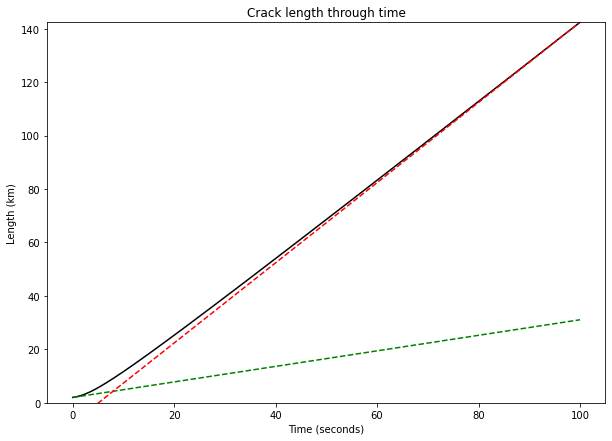

Minimum crack tip speed: 291.0 m/s
Maximum crack tip speed: 1483.0 m/s


In [3]:
'''

Numerical solution to equation 18 in Lipovsky 2018 assuming K = sigima*sqrt(pi*L)

'''

# define the ODE
def simple_tip_motion(L,t,c_r,K_c,sigma):
    K = sigma*np.sqrt(np.pi*L)
    dLdt = c_r*(1-(K_c/K)**2)
    return dLdt

# define material properties ice 
K_c = 250000
c_r = 1500

# define loading configuration
sigma = 3500

# set initial length
L0 = 2000

# define a vector of times
t_max = 100
nt = 1001
t = np.linspace(0, t_max, nt)

# calculate initial stress intensity factor
K = sigma*np.sqrt(np.pi*L0)

# solve the ODE
print("K_c: " + str(np.round(K_c/1000)) + " kPa")
print("K: " + str(np.round(K/1000)) + " kPa")
if K >= K_c:
    L = odeint(simple_tip_motion, L0, t, args=(c_r, K_c, sigma)).reshape(nt)
else:
    L = np.zeros(nt)
    
# estimate minimum and maximum crack tip speeds
crack_speeds = np.diff(L)/np.diff(t)
min_crack_speed = np.min(crack_speeds)
max_crack_speed = np.max(crack_speeds)

# plot crack length as a function of time
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.set_title("Crack length through time")
ax.plot(t,L/1000,color='k')
ax.plot(t,(t*min_crack_speed+L[0])/1000,color='g',linestyle="--")
offset = (t*c_r)[-1] - L[-1]
ax.plot(t,(t*c_r-offset)/1000,color='r',linestyle="--")
ax.set_ylim((0,np.max(L)/1000))
ax.set_ylabel("Length (km)")
ax.set_xlabel("Time (seconds)")
plt.show()
print("Minimum crack tip speed: " + str(np.round(min_crack_speed)) + " m/s")
print("Maximum crack tip speed: " + str(np.round(max_crack_speed)) + " m/s")

In [ ]:
'''

Solve crack tip motion subject to spatially and temporally variable loading with manual time stepping

'''

def solve_tip_motion_iteratively(L0,t,loading):

    # define the ODE
    def tip_motion(L,t,c_r,K_c,sigma):
        K = sigma*np.sqrt(np.pi*L)
        dLdt = c_r*(1-(K_c/K)**2)
        return dLdt

    # iterate through time vector
    L = np.array([])
    K_t = np.array([])
    for time in t:

        # find loading at current crack tip position
        sigma = loading(L0,time)
        K = sigma*np.sqrt(np.pi*L0)
        K_t = np.append(K_t,K)

        # solve the ODE
        if K >= K_c:
            tip_position = odeint(tip_motion, L0, t, args=(c_r, K_c, sigma)).reshape(nt)
        else:
            tip_position = np.ones(nt)*L0

        # save new crack tip position and update crack length
        L = np.append(L,tip_position[1])
        L0 = tip_position[1]

    # get loading as a function of position
    x = np.linspace(L[0],L[-1],1001)
    sigma_x = np.array(list(map(loading, x, np.ones(len(x)))))
    sigma_t = np.array(list(map(loading, np.ones(len(t)), t)))
    K_x = sigma_x*np.sqrt(np.pi*x)
    
    return L, sigma_x, sigma_t, K_x, K_t

In [7]:
'''

Solve crack tip motion subject to spatially and temporally variable allowing odeint to handle the time stepping

'''

def tip_motion(L,t,c_r,K_c,loading):
    sigma = loading(L,t)
    K = sigma*np.sqrt(np.pi*L)
    if  K >= K_c:
        dLdt = c_r*(1-(K_c/K)**2)
    else:
        dLdt = 0
    return dLdt

def get_sigma_and_K(L,t,loading):
    x = np.linspace(L[0],L[-1],len(t))
    sigma_x = np.array(list(map(loading, x, np.ones(len(x)))))
    sigma_t = np.array(list(map(loading, np.ones(len(t)), t)))
    sigma_L = np.array(list(map(loading, L, t)))
    K_x = np.array(list(map(lambda sigma,L: sigma*np.sqrt(np.pi*L), sigma_x, x)))
    K_t = np.array(list(map(lambda sigma,L: sigma*np.sqrt(np.pi*L), sigma_L, L)))
    return sigma_x, sigma_t, K_x, K_t

def solve_tip_motion(t,L0,c_r,K_c,loading):
    L = odeint(tip_motion, L0, t, args=(c_r, K_c, loading)).reshape(len(t))
    sigma_x, sigma_t, K_x, K_t = get_sigma_and_K(L,t,loading)
    return L, sigma_x, sigma_t, K_x, K_t

In [5]:
'''

Function for plotting the model results

'''

def plot_tip_motion(L,t,sigma_x,sigma_t,K_x,K_t):

    # estimate minimum and maximum crack tip speeds
    crack_speeds = np.diff(L)/np.diff(t)
    min_crack_speed = np.min(crack_speeds)
    max_crack_speed = np.max(crack_speeds)    
    max_crack_speed_ind = np.argmax(crack_speeds)
    
    # plot stress profile in space
    fig,ax = plt.subplots(5,1,figsize=(15,20))
    x = np.linspace(L[0],L[-1],1001)
    ax[0].set_title("Stress $\sigma(x)$",fontsize=20)
    ax[0].plot(x/1000,sigma_x/1000,color='k')
    if np.sum(np.diff(sigma_t)) != 0:
        ax[0].set_ylim((np.min(sigma_x)/1000,np.max(sigma_x)/1000))
    ax[0].set_xlim(x[0]/1000,x[-1]/1000)
    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].set_ylabel("Stress (kPa)",fontsize=13)
    ax[0].set_xlabel("Length (km)",fontsize=13)
    
    # plot stress profile in time
    ax[1].set_title("Stress $\sigma(t)$",fontsize=20)
    ax[1].plot(t,sigma_t/1000,color='k')
    if np.sum(np.diff(sigma_t)) != 0:
        ax[1].set_ylim((np.min(sigma_t)/1000,np.max(sigma_t)/1000))
    ax[1].set_xlim(t[0],t[-1])
    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].set_ylabel("Stress (kPa)",fontsize=13)
    ax[1].set_xlabel("Time (seconds)",fontsize=13)

    # plot stress intensity factor as a function of space
    ax[2].set_title("Stress intensity factor $K(x)$",fontsize=20)
    ax[2].plot(x/1000,K_x/1000,color='k')
    ax[2].hlines(K_c/1000,xmin=x[0]/1000,xmax=x[-1]/1000,color='r',linestyle='--',label="Critical stress intensity factor $K_c$")
    ax[2].legend(fontsize=15)
    ax[2].set_ylim((K_c/1000-10,np.max(K_x)/1000+2))
    ax[2].set_xlim(x[0]/1000,x[-1]/1000)
    ax[2].tick_params(axis='both', which='major', labelsize=13)
    ax[2].set_ylabel("Stress intensity factor $(kPa\sqrt{m})$",fontsize=13)
    ax[2].set_xlabel("Length (km)",fontsize=13)

    # plot stress intensity factors through time
    ax[3].set_title("Stress intensity factor $K(t)$",fontsize=20)
    ax[3].plot(t,K_t/1000,color='k')
    ax[3].hlines(K_c/1000,0,t[-1],color='r',linestyle='--',label="Critical stress intensity factor $K_c$")
    ax[3].legend(fontsize=15)
    if K_c < np.min(K_t):
        ax[3].set_ylim((K_c/1000-10,np.max(K_t)/1000+2))
    else:
        ax[3].set_ylim((np.min(K_t)/1000-10,np.max(K_t)/1000+2))
    ax[3].set_xlim(0,t[-1])
    ax[3].tick_params(axis='both', which='major', labelsize=13)
    ax[3].set_ylabel("Stress intensity factor $(kPa\sqrt{m})$",fontsize=13)
    ax[3].set_xlabel("Time (s)",fontsize=13)
    
    # plot crack tip position through time
    ax[4].set_title("Crack length L(t)",fontsize=20)
    ax[4].plot(t,L/1000,color='k')
    offset = (t*c_r)[max_crack_speed_ind] - L[max_crack_speed_ind]
    ax[4].plot(t,(t*c_r-offset)/1000,color='b',linestyle="--",label="Rayleigh wave speed $c_r$")
    ax[4].legend(fontsize=15)
    ax[4].set_ylim((0,np.max(L)/1000+2))
    ax[4].set_xlim(0,t[-1])
    ax[4].tick_params(axis='both', which='major', labelsize=13)
    ax[4].set_ylabel("Length (km)",fontsize=13)
    ax[4].set_xlabel("Time (seconds)",fontsize=13)
    plt.tight_layout()
    plt.show()
    print("Minimum crack tip speed: " + str(np.round(min_crack_speed)) + " m/s")
    print("Maximum crack tip speed: " + str(np.round(max_crack_speed)) + " m/s")

In [8]:
'''

Solve and plot crack tip motion for a variety of loading configurations

'''

# set ice material properties 
K_c = 250000
c_r = 1500

# set initial length
L0 = 2000

# define a vector of times
t_max = 100
nt = 1001
t = np.linspace(0, t_max, nt)

In [ ]:
# define loading configuration
def loading(x,t):
    sigma = 3500
    return sigma

# solve and plot the crack tip motion
L,sigma_x,sigma_t,K_x,K_t = solve_tip_motion(t,L0,c_r,K_c,loading)
plot_tip_motion(L,t,sigma_x,sigma_t,K_x,K_t)

In [ ]:
# define loading configuration
def loading(x,t):
    sigma = 5000 - 0.25 * x
    return sigma

# solve and plot the crack tip motion
L,sigma_x,sigma_t,K_x,K_t = solve_tip_motion(t,L0,c_r,K_c,loading)
plot_tip_motion(L,t,sigma_x,sigma_t,K_x,K_t)

In [ ]:
# define loading configuration
def loading(x,t):
    sigma = 4500 + 2500 * np.sin(x/1000)
    return sigma

# solve and plot the crack tip motion
L,sigma_x,sigma_t,K_x,K_t = solve_tip_motion(t,L0,c_r,K_c,loading)
plot_tip_motion(L,t,sigma_x,sigma_t,K_x,K_t)

In [ ]:
# define loading configuration
def loading(x,t):
    sigma = 5500 + 2500 * np.sin(x/1000)
    return sigma

# solve and plot the crack tip motion
L,sigma_x,sigma_t,K_x,K_t = solve_tip_motion(t,L0,c_r,K_c,loading)
plot_tip_motion(L,t,sigma_x,sigma_t,K_x,K_t)

In [ ]:
# define loading configuration
def loading(x,t):
    sigma = 2000 + 2500 * np.sin(t/10)
    return sigma

# solve and plot the crack tip motion
L,sigma_x,sigma_t,K_x,K_t = solve_tip_motion(t,L0,c_r,K_c,loading)
plot_tip_motion(L,t,sigma_x,sigma_t,K_x,K_t)

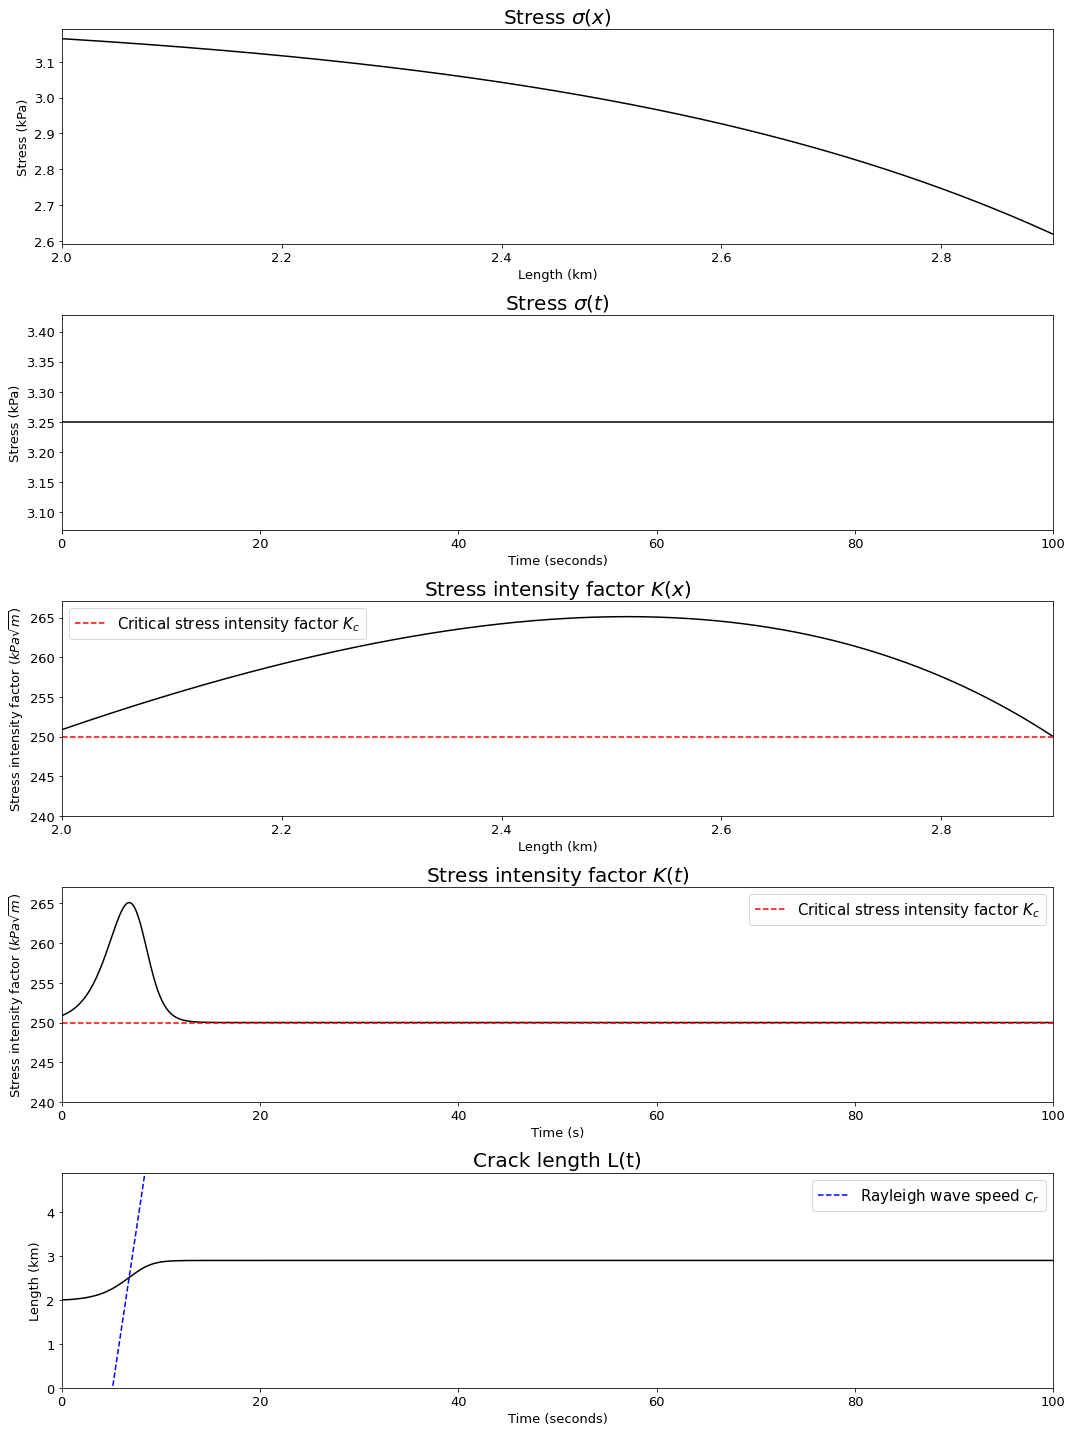

Minimum crack tip speed: -0.0 m/s
Maximum crack tip speed: 166.0 m/s


In [9]:
# define loading configuration
def loading(x,t):
    sigma = 3250 - np.exp(x/450)
    return sigma

# solve and plot the crack tip motion
L,sigma_x,sigma_t,K_x,K_t = solve_tip_motion(t,L0,c_r,K_c,loading)
plot_tip_motion(L,t,sigma_x,sigma_t,K_x,K_t)

In [48]:
def water_motion(U,t,H_w,H_c,L_c,w,L,rho_w,model):
    eta, xi = U
    if model == 'linear-constant-l-and-w':
        d_eta_dt = xi
        d_xi_dt = 9.8*(H_w-H_c-eta)/(w*L_c/H_c)
    elif model == 'nonlinear-constant-l-and-w':
        d_eta_dt = xi
        d_xi_dt = (9.8*(H_w-H_c-eta)-(1/2)*(1-(w/H_c)**2)*xi**2)/(w*L_c/H_c+eta)
    
    dUdt = [d_eta_dt,
            d_xi_dt]
    
    return dUdt

In [49]:
'''

Solve water motion with odeint

'''

# set material properties
rho_i = 910
rho_w = 1000

# set shelf geometry
H_i = 100
H_w = 500
H_c = H_w - rho_i/rho_w*H_i
L_c = 10000

# set rift geometry
w = 100
L = 1000

# set initial conditions
U0 = [0,0]

# define a vector of times
t_max = 1000
nt = 1001
t = np.linspace(0, t_max, nt)

# solve the linear ODE with odeint
U = odeint(water_motion, U0, t, args=(H_w, H_c, L_c, w, L, rho_w,'linear-constant-l-and-w'))
eta_linear = U[:,0]

# solve the nonlinear ODE with odeint
U = odeint(water_motion, U0, t, args=(H_w, H_c, L_c, w, L, rho_w,'nonlinear-constant-l-and-w'))
eta_nonlinear = U[:,0]

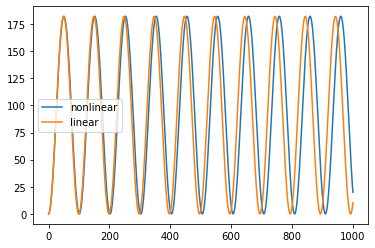

In [50]:
plt.figure()
plt.plot(eta_nonlinear,label="nonlinear")
plt.plot(eta_linear,label="linear")
plt.legend()
plt.show()